# LLM Evaluation for Pairwise Choice Task

This notebook implements the evaluation pipeline for the `task_2_pairwise_preference` dataset. This task tests the LLM's ability to choose between two recipes ("Recipe A" and "Recipe B") based on a user's history.

We are using the `_shuffled.json` version of the file, which has been pre-processed to fix a 100% "Recipe A" bias, ensuring a fair and balanced evaluation.

The process is:
1.  **Setup**: Install libraries and initialize the OpenAI API client.
2.  **Helper Functions**: Define the core functions for API calls and result-saving.
3.  **Task Evaluation**: Run the full evaluation, using a `label_map` to parse the `instruction_output` correctly.
4.  **Final Analysis**: Analyze and report the final Accuracy and F1-Score for each model.

### 1. Environment Setup

In [1]:
#%pip install openai python-dotenv scikit-learn matplotlib tqdm pandas

### 2. Imports, API Initialization, and Constants

In [4]:
import json
import os
import time
import random
from openai import OpenAI
from dotenv import load_dotenv
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

# --- API and Model Configuration ---
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# The models we will compare
MODELS_TO_TEST = ["gpt-3.5-turbo", "gpt-4o"]

# The JSON instruction for the prompt
JSON_INSTRUCTION = (
    "Your response MUST be a JSON object with a single key 'prediction' "
    "whose value is one of the following exact strings: {labels}."
)

# Ensure a directory for results exists
os.makedirs('results', exist_ok=True)

### 3. Core Helper Functions

In [5]:
def load_json_file(file_path):
    """Loads a JSON file safely."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None

def save_results(results, file_path):
    """Saves a list of dictionaries to a JSON file."""
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2)
    print(f"Successfully saved {len(results)} results to {file_path}")

def get_prompt(instruction_input, valid_labels):
    """Builds the single, simple prompt for the LLM."""
    labels_str = str(valid_labels)
    return f"{instruction_input}\n\n{JSON_INSTRUCTION.format(labels=labels_str)}"

def get_llm_prediction(client, model_name, prompt):
    """Calls the correct API endpoint based on the model and gets a prediction."""
    retries = 3
    delay = 5  # Start with a 5-second delay for robustness

    for attempt in range(retries):
        try:
            content = None
            if model_name == "gpt-5-pro":
                # Use the older Completions API for this model
                response = client.completions.create(
                    model=model_name,
                    prompt=prompt,
                    max_tokens=150,
                    temperature=0
                )
                content = response.choices[0].text
            else:
                # Use the modern Chat Completions API for other models
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[{"role": "user", "content": prompt}],
                    response_format={"type": "json_object"},
                    temperature=0
                )
                content = response.choices[0].message.content
            
            # Parse the content to extract the prediction
            json_start_index = content.find('{')
            if json_start_index == -1:
                return "parsing_error"
            
            json_content = content[json_start_index:]
            prediction_json = json.loads(json_content)
            return prediction_json.get("prediction", "parsing_error")
        
        except Exception as e:
            print(f"API Error ({model_name}): {e}. Retrying... (Attempt {attempt + 1}/{retries})")
            time.sleep(delay)
            delay *= 2  # Exponential backoff
            
    return "api_error" # Failed after all retries

def run_evaluation(client, data_file_path, valid_labels, unique_id_keys, sample_count=None, label_map=None):
    """
    Runs the full evaluation pipeline for a single data file.
    - sample_count: If provided, runs on a random sample of this many instructions.
    - label_map: An optional dictionary to map messy instruction_outputs to clean labels.
    """
    
    task_name = os.path.basename(data_file_path).split('.')[0]
    results_path = f"results/results_{task_name}.json"
    
    print(f"\n{'='*20} Starting Evaluation for: {task_name} {'='*20}")
    
    # --- Load all instructions from the data file ---
    all_instructions = load_json_file(data_file_path)
    if not all_instructions:
        return

    # --- Sampling Logic ---
    instructions = all_instructions
    if sample_count:
        actual_sample_count = min(sample_count, len(all_instructions))
        random.seed(42)
        instructions = random.sample(all_instructions, actual_sample_count)
        print(f"Original dataset size: {len(all_instructions)}. Using a random sample of {len(instructions)} instructions.")
    else:
        print(f"Using the full dataset of {len(instructions)} instructions.")

    # --- Load existing results (for resuming) ---
    all_results = []
    processed_keys = set()
    if os.path.exists(results_path):
        all_results = load_json_file(results_path)
        for res in all_results:
            key_tuple = (res['model_name'],) + tuple(res[k] for k in unique_id_keys)
            processed_keys.add(key_tuple)
        print(f"Loaded {len(all_results)} existing results. Resuming...")

    api_calls_made = 0

    # --- Main evaluation loop ---
    for model_name in MODELS_TO_TEST:
        print(f"\n--- Processing Model: {model_name} ---")
        
        for instruction in tqdm(instructions, desc=f"Model: {model_name}"):
            id_values = [instruction.get(k) for k in unique_id_keys]
            current_key = (model_name,) + tuple(id_values)

            if current_key in processed_keys:
                continue
            
            prompt = get_prompt(instruction['instruction_input'], valid_labels)
            prediction = get_llm_prediction(client, model_name, prompt)
            api_calls_made += 1
            
            # --- Label Mapping Logic ---
            true_label_raw = instruction['instruction_output']
            true_label = true_label_raw # Default if no map
            
            if label_map:
                mapped_label = "Other/Unknown" # default
                for key_prefix, simple_label in label_map.items():
                    if true_label_raw.startswith(key_prefix):
                        mapped_label = simple_label
                        break
                true_label = mapped_label
            # --- END Label Mapping Logic ---
            
            result_record = {
                "model_name": model_name,
                "full_prompt_sent": prompt,
                "llm_prediction": prediction,
                "true_label": true_label,
                "is_correct": prediction == true_label,
                "timestamp": time.time()
            }
            for key, value in zip(unique_id_keys, id_values):
                result_record[key] = value
                
            all_results.append(result_record)
            processed_keys.add(current_key)
            
            if len(all_results) % 100 == 0:
                save_results(all_results, results_path)

    save_results(all_results, results_path)
    print(f"\nTotal new API calls made in this run: {api_calls_made}")
    print(f"\n{'='*20} Evaluation COMPLETE for: {task_name} {'='*20}")

### 4. Evaluation: Task 2 - Pairwise Preference

This task evaluates the LLM's ability to choose between "Recipe A" and "Recipe B". We are using the `_shuffled` file to ensure the data is not biased.

We define `VALID_LABELS` as the clean labels we want from the LLM, and `LABEL_MAP_2` to convert the messy `instruction_output` (e.g., "Recipe A: Turkey Nachos") into its corresponding clean label.

In [7]:
DATA_FILE_PATH_2 = 'data/task_2_pairwise_preference 3_shuffled.json'
VALID_LABELS_2 = ["Recipe A", "Recipe B"]
# This map converts the *messy* instruction_output into our clean labels
LABEL_MAP_2 = {
    "Recipe A": "Recipe A",
    "Recipe B": "Recipe B"
}
 
UNIQUE_ID_KEYS_2 = ['user_id', 'target_recipe_id']

sample_percentage = 0.1
sample_count = int(sample_percentage * 15924)

# --- Run Evaluation on a sample of 1000 ---
run_evaluation(client, DATA_FILE_PATH_2, VALID_LABELS_2, UNIQUE_ID_KEYS_2, sample_count, label_map=LABEL_MAP_2)


==================== Starting Evaluation for: task_2_pairwise_preference 3_shuffled ====================
Original dataset size: 15924. Using a random sample of 1592 instructions.

--- Processing Model: gpt-3.5-turbo ---


Model: gpt-3.5-turbo:   0%|          | 0/1592 [00:00<?, ?it/s]

Successfully saved 100 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 200 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 300 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 400 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 500 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 600 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 700 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 800 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 900 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 1000 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 1100 results to results/results_task_2_pairwise_pr

Model: gpt-4o:   0%|          | 0/1592 [00:00<?, ?it/s]

Successfully saved 1600 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 1700 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 1800 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 1900 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 2000 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 2100 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 2200 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 2300 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 2400 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 2500 results to results/results_task_2_pairwise_preference 3_shuffled.json
Successfully saved 2600 results to results/results_task_2_pa

### 5. Final Analysis

This cell loads the `results_task_2...json` file and calculates the final metrics. For a 2-class (binary) problem, **Accuracy is the most important and interpretable metric.**

We will also show:
* **F1-Score (Weighted):** Still useful, but for a balanced binary case, it will be very close to the accuracy.
* **Confusion Matrix:** This will show us exactly what kind of mistakes the models are making (e.g., did they mistakenly choose 'B' when 'A' was correct?).

Loaded a total of 3184 predictions.


--- 🚀 Final Performance Summary ---
| model_name    |   accuracy |   f1_score_weighted |
|:--------------|-----------:|--------------------:|
| gpt-3.5-turbo |     0.7902 |              0.7899 |
| gpt-4o        |     0.8417 |              0.8417 |


C:\Users\amollaza24\AppData\Local\Temp\ipykernel_14940\1251977257.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = full_df.groupby('model_name').apply(lambda x: pd.Series({


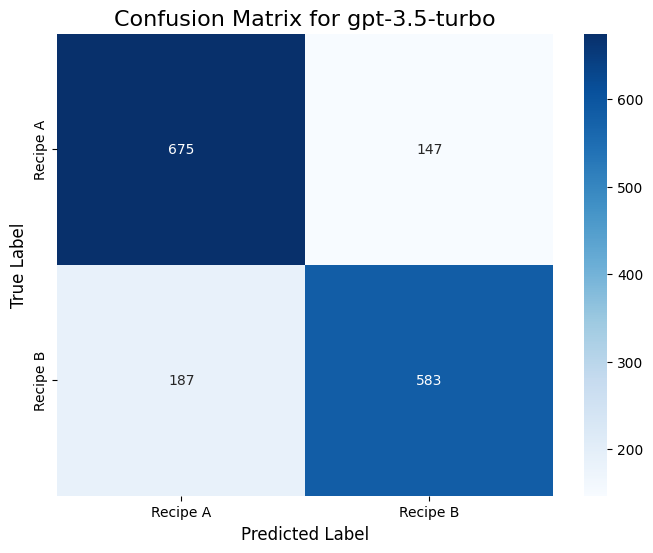

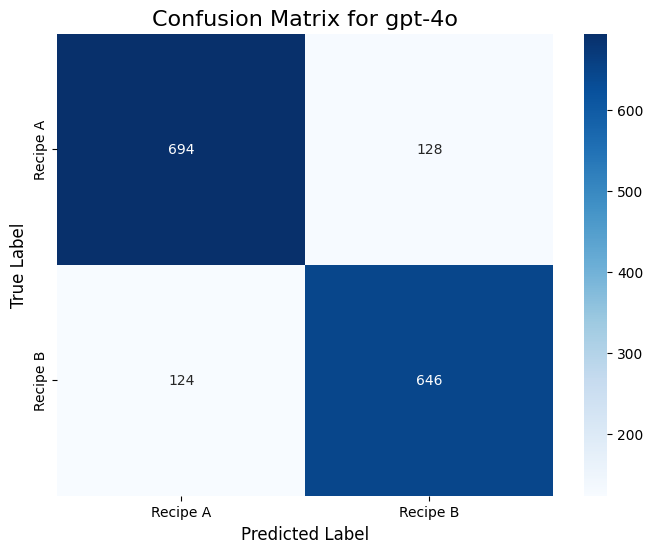

In [8]:
# --- Load the result file ---
results_dir = 'results'
task_2_results_file = 'results_task_2_pairwise_preference 3_shuffled.json'
results_path = os.path.join(results_dir, task_2_results_file)

if not os.path.exists(results_path):
    print("No result file found. Please run the evaluation cell first.")
else:
    full_df = pd.read_json(results_path)
    print(f"Loaded a total of {len(full_df)} predictions.")

    # --- Calculate metrics for each model ---
    summary = full_df.groupby('model_name').apply(lambda x: pd.Series({
        'accuracy': accuracy_score(x['true_label'], x['llm_prediction']),
        'f1_score_weighted': f1_score(x['true_label'], x['llm_prediction'], average='weighted', zero_division=0)
    })).reset_index()

    # --- Display Summary Tables ---
    print("\n\n--- 🚀 Final Performance Summary ---")
    print(summary.to_markdown(index=False, floatfmt=".4f"))
    
    # --- Display Confusion Matrices ---
    models = full_df['model_name'].unique()
    for model in models:
        model_df = full_df[full_df['model_name'] == model]
        y_true = model_df['true_label']
        y_pred = model_df['llm_prediction']
        
        cm = confusion_matrix(y_true, y_pred, labels=VALID_LABELS_2)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=VALID_LABELS_2, yticklabels=VALID_LABELS_2)
        plt.title(f'Confusion Matrix for {model}', fontsize=16)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.show()